In [2]:
import pandas as pd
reviews = pd.read_csv("../data/reviews_cleaned.csv")

In [5]:
reviews.head()

,Unnamed: 0,review,sentiment
0,0,one reviewer mentioned watching oz episode you...,positive
1,1,wonderful little production filming technique ...,positive
2,2,thought wonderful way spend time hot summer we...,positive
3,3,basically there family little boy jake think t...,negative
4,4,petter matteis love time money visually stunni...,positive


In [6]:
reviews = reviews.set_index('Unnamed: 0')
reviews.tail()

,review,sentiment
Unnamed: 0,,
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative
49999,no one expects star trek movie high art but fa...,negative


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
X_train, X_test, y_train, y_test = train_test_split(reviews['review'], reviews['sentiment'], test_size = .2, stratify=reviews['sentiment'], random_state=42)

In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", X_test.shape)

X_train shape: (39665,)
y_train shape: (39665,)
X_test shape: (9917,)
y_test shape: (9917,)


In [10]:
# First explore using bag of words and tfidf

In [11]:
cv = CountVectorizer(ngram_range=(1,2),  max_features=10000)
cv_train_features = cv.fit_transform(X_train)

In [12]:

tv = TfidfVectorizer(ngram_range=(1,2),  sublinear_tf=True, max_features=10000)
tv_train_features = tv.fit_transform(X_train)

In [13]:
# transform test reviews into features
cv_test_features = cv.transform(X_test)
tv_test_features = tv.transform(X_test)

In [14]:
print('BOW model:> Train features shape:', cv_train_features.shape, 'Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (39665, 10000) Test features shape: (9917, 10000)


In [15]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, 'Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (39665, 10000) Test features shape: (9917, 10000)


# Visualize

Based on this blog post: https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

lsa = TruncatedSVD(n_components=2)

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['positive', 'negative'])
le.classes_
y_train_trans = le.transform(y_train)

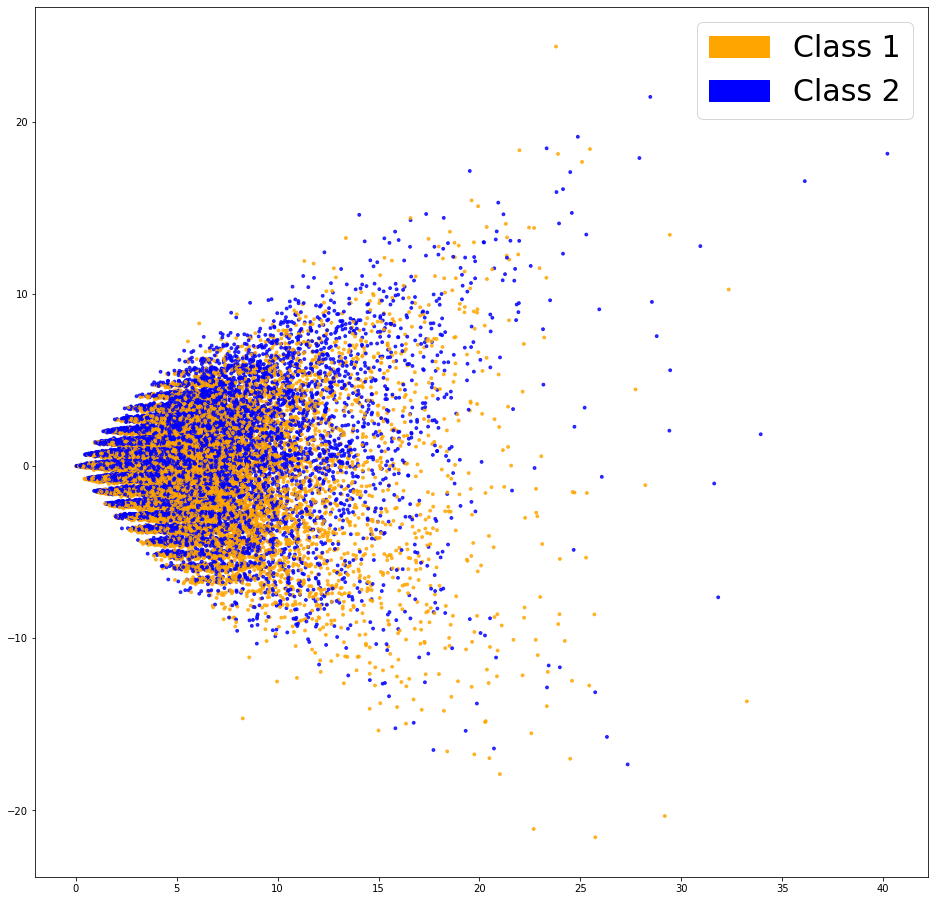

In [15]:
## Plot Bag of words features

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Class 1')
            green_patch = mpatches.Patch(color='blue', label='Class 2')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(cv_train_features, y_train_trans)
plt.show()

Features are not linearly separable, likely won't perform well

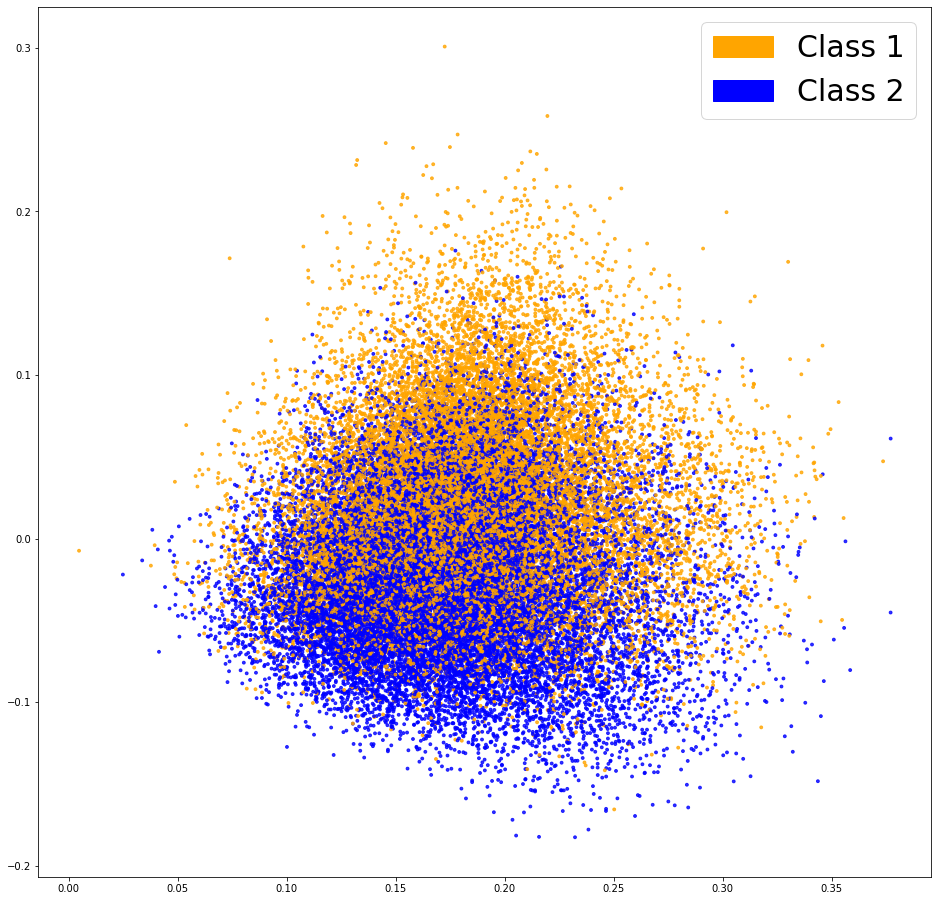

In [16]:
## Plot Tfidf features

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Class 1')
            green_patch = mpatches.Patch(color='blue', label='Class 2')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(tv_train_features, y_train_trans)
plt.show()

Improvement over bag of words

# Model


In [16]:
from sklearn.pipeline import Pipeline

In [17]:
'''Initialize all pipelines'''

seed = 43

'''#1.Logistic Regression w/ Bag of Words'''
from sklearn.linear_model import LogisticRegression
pipe_lr = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2),  max_features=10000)),
    ('lr_bow', LogisticRegression(solver='liblinear')),
])

'''#2.Naive Bayes w/ Bag of Words'''
from sklearn.naive_bayes import MultinomialNB
pipe_nb = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2),  max_features=10000)),
    ('nb_bow', MultinomialNB()),
])

'''#3.Logistic Regresion w/ TFIDF'''
lr_tfidf = Pipeline([
    ('tv', TfidfVectorizer(ngram_range=(1,2),  sublinear_tf = True, max_features=10000)),
    ('lr_tfidf', LogisticRegression(solver='liblinear')),
])

'''#4.Naive Bayes w/ TFIDF'''
nb_tfidf = pipe_nb = Pipeline([
    ('tv', TfidfVectorizer(ngram_range=(1,2),  sublinear_tf = True, max_features=10000)),
    ('nb_tfidf', MultinomialNB()),
])

In [18]:
# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_nb, lr_tfidf, nb_tfidf]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression - Bag O Words', 1: 'Naive Bayes - Bag O Words', 
             2: 'Logistic Regression - Tfidf', 3: 'Naive Bayes - Tfidf'}

In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

def train_accuracy(model):
    train_accuracy = model.score(X_train,y_train)
    train_accuracy = np.round(train_accuracy*100,2)
    return train_accuracy

In [21]:
def train_precision(model):   
    precision = precision_score(predictions, y_train,  pos_label='positive')
    precision = np.round(precision*100,2)
    return precision

In [22]:
def train_recall(model):
    recall = recall_score(predictions, y_train,  pos_label='positive')
    recall = np.round(recall*100,2)
    return recall

In [23]:
metrics = {}
for idx, val in enumerate(pipelines):
    val.fit(X_train, y_train)
    predictions = val.predict(X_train)
    accuracy = train_accuracy(val)
    precision = train_precision(val)
    recall = train_recall(val)
    metrics[pipe_dict[idx]] = [accuracy, precision, recall]

In [24]:
metrics_df = pd.DataFrame(metrics)
metrics_df.columns = ['Logistic Regression - Bag O Words', 'Naive Bayes - Bag O Words', 
             'Logistic Regression - Tfidf', 'Naive Bayes - Tfidf']
metrics_df.index = ['accuracy', 'precision', 'recall']
metrics_df

,Logistic Regression - Bag O Words,Naive Bayes - Bag O Words,Logistic Regression - Tfidf,Naive Bayes - Tfidf
accuracy,98.24,88.12,92.76,88.12
precision,98.39,89.43,93.52,89.43
recall,98.12,87.22,92.17,87.22


Looks like it could be overfitting with LR-BOW and underfitting with Naive Bayes

In [25]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(pipe_lr['cv'], pipe_lr['lr_bow'], 10)

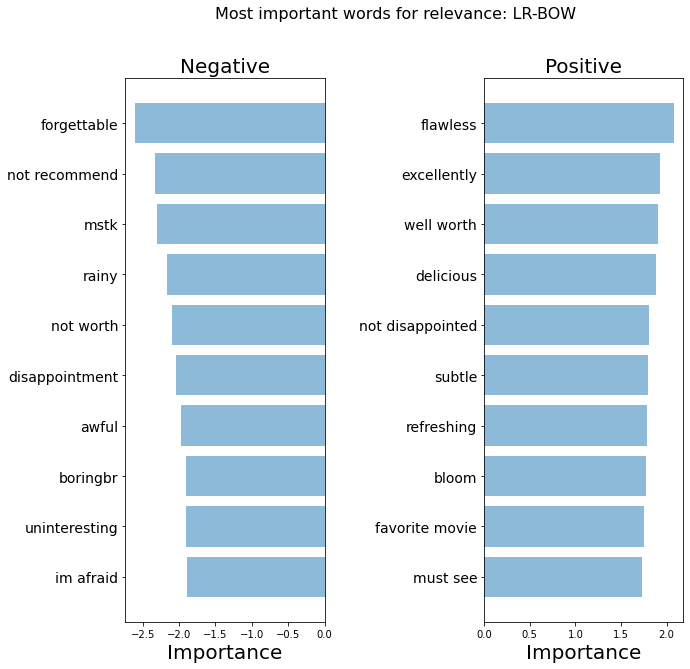

In [26]:
import numpy as np

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance: LR-BOW")

Logistic Regression - Bag O Words


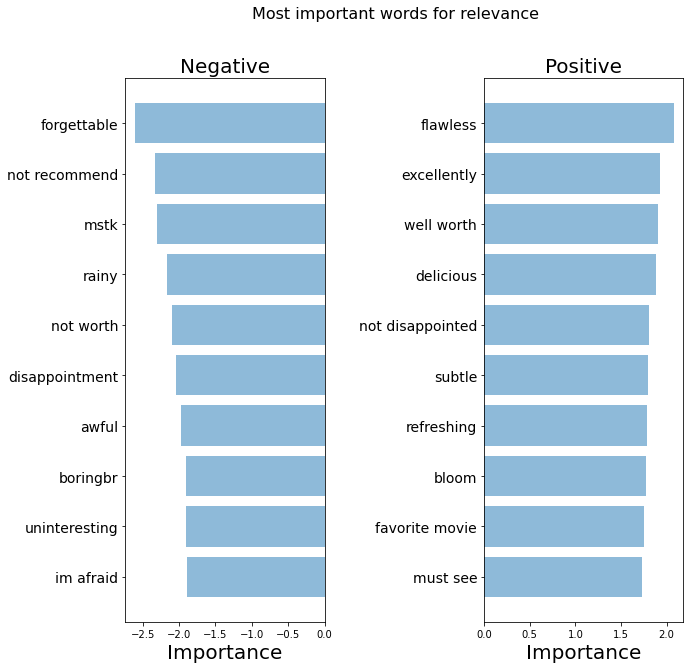

Naive Bayes - Bag O Words


/home/julie/virtual-env/nlp_updated/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


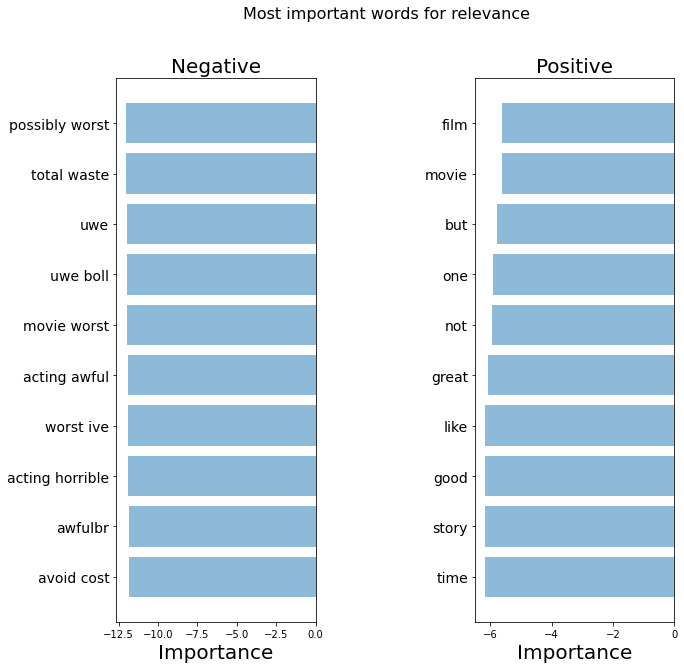

Logistic Regression - Tfidf


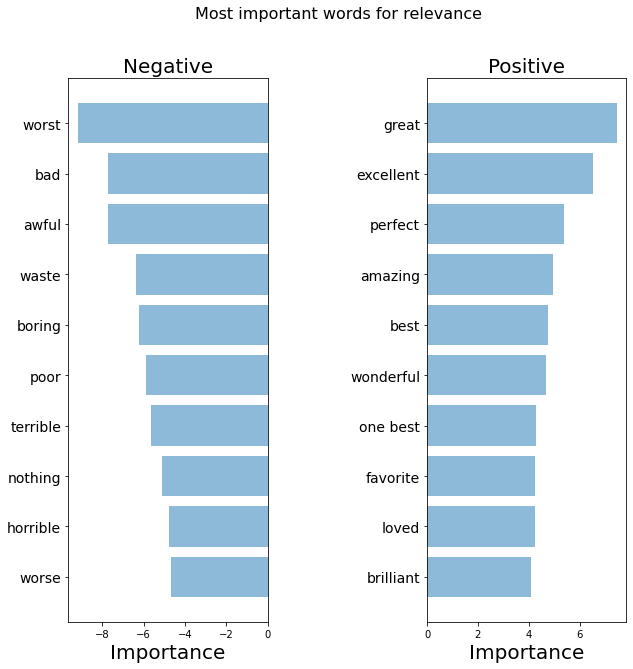

Naive Bayes - Tfidf


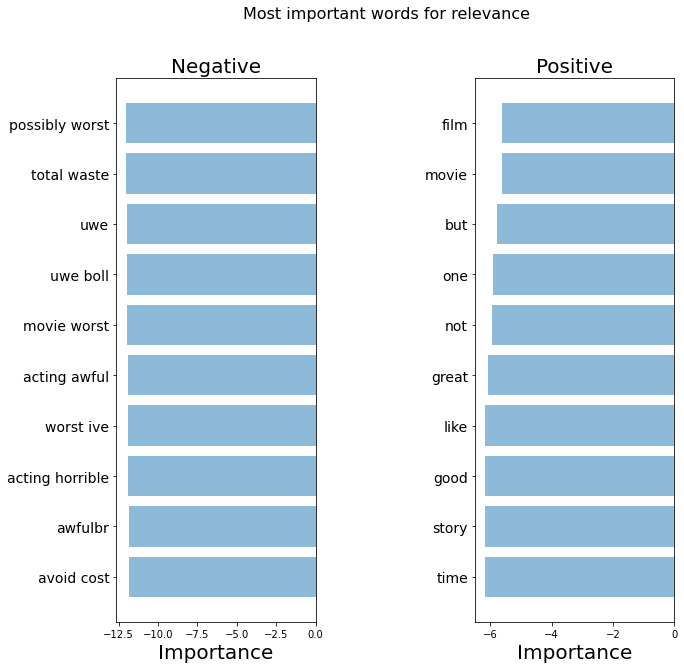

In [27]:
import matplotlib.pyplot as plt 

for idx, val in enumerate(pipelines):
    importance = get_most_important_features(val[0], val[1], 10)
    
    top_scores = [a[0] for a in importance[0]['tops']]
    top_words = [a[1] for a in importance[0]['tops']]
    bottom_scores = [a[0] for a in importance[0]['bottom']]
    bottom_words = [a[1] for a in importance[0]['bottom']]
    
    print(pipe_dict[idx])
    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Precision/recall is higher for logistic regression and the words it is picking up on make more sense

In [ ]:
# Cross Validation

In [28]:
from sklearn.model_selection import cross_validate

'''Functions that returns mean cross validation score for different models.'''
def x_val_score(model, metric='accuracy'):
    from sklearn.model_selection import cross_val_score
    x_val_score = cross_val_score(model, X_train, y_train_trans, cv=5, scoring=metric).mean()
    x_val_score = np.round(x_val_score*100,2)
    return x_val_score

In [29]:
'''Perform k-fold (k=10) corss validation to find classifier with best cross validation accuracy.'''
x_val_score = pd.DataFrame({'X_val_score(%)':[x_val_score(pipe_lr),
                                              x_val_score(pipe_nb),
                                              x_val_score(lr_tfidf),
                                              x_val_score(nb_tfidf)]})

x_val_score.index = ['LR-BOW', 'NB-BOW', 'LR-TFIDF', 'NB-TFIDF']

sorted_x_val_score = x_val_score.sort_values(by = 'X_val_score(%)', ascending=False)
print('**Models 5-fold Cross Validation Score:**')
print(sorted_x_val_score)

**Models 10-fold Cross Validation Score:**
          X_val_score(%)
LR-TFIDF           89.59
LR-BOW             87.18
NB-BOW             86.87
NB-TFIDF           86.87


In [30]:
def x_val_metrics(model, metric='accuracy'):
    from sklearn.model_selection import cross_val_score
    #stratified kfold is automatically used in cross_val_score for classifiers
    #if labels are text, need to transform them to numberS 
    x_val_score = cross_validate(model, X_train, y_train_trans, cv=5, scoring=metric)
    return x_val_score

In [35]:
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision',
           'rec_micro': 'recall'}

'''Perform k-fold (k=10) corss validation to find classifier with best cross validation accuracy.'''
x_val_dict = {'X_val_precision(%)':[x_val_metrics(pipe_lr, metric=scoring),
                                    x_val_metrics(pipe_nb, metric=scoring),
                                    x_val_metrics(lr_tfidf, metric=scoring),
                                    x_val_metrics(nb_tfidf, metric=scoring)]}

In [37]:
scores_df = pd.DataFrame(x_val_dict['X_val_precision(%)'])
print('**Models 5-fold Cross Validation:**')
for column in scores_df.columns:
    scores_df[column] = scores_df[column].apply(lambda x: sum(x)/len(x))
scores_df.index = ['LR-BOW', 'NB-BOW', 'LR-TFIDF', 'NB-TFIDF']
scores_df

,fit_time,score_time,test_acc,test_prec_macro,test_rec_micro
LR-BOW,33.091083,2.043124,0.871751,0.868744,0.876978
NB-BOW,18.931947,1.634482,0.868700,0.859497,0.882704
LR-TFIDF,16.377288,1.284834,0.895878,0.887951,0.907017
NB-TFIDF,16.035648,1.235374,0.868700,0.859497,0.882704


In [ ]:
LR-TFIDF - highest recall/precision

# Tune Hyperparameters

In [20]:
'''Define all models' hyperparamters one by one first:'''

'''Define hyperparameters for Logistic Regression. The following are usually tuned:'''
import numpy as np

lr_params = {'lr_tfidf__penalty':['l1', 'l2'],
            'lr_tfidf__C': np.logspace(0, 4, 10)}


In [21]:
'''Function to tune hyperparameters:'''
def tune_hyperparameters(model, params):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 5 fold cross validation
    grid = GridSearchCV(model, params, verbose=0, cv=5, scoring='accuracy', n_jobs=-1)
    #Fit using grid search
    grid.fit(X_train, y_train)
    best_params, best_score = grid.best_params_, np.round(gride.best_score_*100,2)
    return best_params, best_score

In [ ]:
'''Tune LR hyperparamters'''
tune_hyperparameters(lr_tfidf, params=lr_params)
lr_best_params, lr_best_score = best_params, best_score
print('LR Best Score', lr_best_score)
print('Best Parameters', lr_best_params)

# Test Model

In [19]:
lr_tfidf.fit(X_train, y_train)
predictions = lr_tfidf.predict(X_test)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4940
    positive       0.89      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [21]:
import pickle 
filename = 'sentiment.pkl'
pickle.dump(lr_tfidf, open(f"../models/{filename}", 'wb'))

In [23]:
%timeit model = pickle.load(open(f"../models/{filename}", 'rb'))

437 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
